<h2>Import All of the Appropriate Libraries for the project

In [160]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files


!conda install -c conda-forge geopy --yes
!pip install geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print("Libraries imported.")

# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: | ^C
failed

CondaError: KeyboardInterrupt

Libraries imported.
Solving environment: | ^C
failed

CondaError: KeyboardInterrupt

Wordcloud is installed and imported!


<h2>Start with the most popular suburbs north of Atlanta

In [161]:
# initialize list of lists 
cities = [['Dunwoody', 'GA'], ['Sandy Springs', 'GA'], ['Roswell','GA'],['Woodstock','GA'],['Norcross','GA'],['Suwanee','GA'],['Alpharetta','GA'],['Marietta','GA'],['Duluth','GA']] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(cities, columns = ['City', 'State']) 
  
# print dataframe. 
df 

,City,State
0,Dunwoody,GA
1,Sandy Springs,GA
2,Roswell,GA
3,Woodstock,GA
4,Norcross,GA
5,Suwanee,GA
6,Alpharetta,GA
7,Marietta,GA
8,Duluth,GA


<h2>Get the GPS coordinates for each of the suburbs

In [163]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, GA'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [164]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in df["City"].tolist() ]

In [165]:
coords

[[33.92620000000005, -84.33617999999996],
 [33.92483000000004, -84.37907999999999],
 [34.021660000000054, -84.35929999999996],
 [34.102910000000065, -84.51874999999995],
 [33.942810000000065, -84.21094999999997],
 [34.05746000000005, -84.06474999999995],
 [34.07540000000006, -84.29454999999996],
 [33.95319000000006, -84.54587999999995],
 [34.003630000000044, -84.14536999999996]]

In [166]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [167]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [168]:
# check the neighborhoods and the coordinates
print(df.shape)
df

(9, 4)


,City,State,Latitude,Longitude
0,Dunwoody,GA,33.92620,-84.33618
1,Sandy Springs,GA,33.92483,-84.37908
2,Roswell,GA,34.02166,-84.35930
3,Woodstock,GA,34.10291,-84.51875
4,Norcross,GA,33.94281,-84.21095
5,Suwanee,GA,34.05746,-84.06475
6,Alpharetta,GA,34.07540,-84.29455
7,Marietta,GA,33.95319,-84.54588
8,Duluth,GA,34.00363,-84.14537


<h2>Create a map to show the location of the key suburbs.  Center the map around Roswell since all the suburbs are north of Atlanta

In [196]:
# get the coordinates of Roswell, GA
address = 'Roswell, GA'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Roswell, GA {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Roswell, GA 34.02332, -84.360022.


In [197]:
# create map of Atlanta Cities using Roswell latitude and longitude values as the center
map_atl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['City']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_atl)  
    
map_atl

<h2>Use Foursquare to get the top Restaurants in each of the key suburbs

In [198]:
# define Foursquare Credentials and Version
CLIENT_ID = 'MKIX5GO0RCMABWJ2HYMBTLBHAMHSPZLQTVSXOEH24SA5BHG4' # your Foursquare ID
CLIENT_SECRET = 'GNFV4N01EC4LK2EJEMVD25J2UNKCR3COGSBNZ4LWO30JFLVX' # your Foursquare Secret
VERSION = '20180602' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MKIX5GO0RCMABWJ2HYMBTLBHAMHSPZLQTVSXOEH24SA5BHG4
CLIENT_SECRET:GNFV4N01EC4LK2EJEMVD25J2UNKCR3COGSBNZ4LWO30JFLVX


In [199]:
radius = 2000
LIMIT = 200
CATEGORYID = '4d4b7105d754a06374d81259'

venues = []

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['City']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT,
        CATEGORYID
    )
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [200]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['City', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head(10)

(530, 7)


,City,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Dunwoody,33.9262,-84.33618,Alon's Bakery & Market,33.924560,-84.336402,Bakery
1,Dunwoody,33.9262,-84.33618,The Capital Grille,33.926564,-84.340573,American Restaurant
2,Dunwoody,33.9262,-84.33618,Seasons 52,33.926519,-84.339795,New American Restaurant
3,Dunwoody,33.9262,-84.33618,McKendrick's Steak House,33.925110,-84.335980,Steakhouse
4,Dunwoody,33.9262,-84.33618,Eclipse di Luna,33.924995,-84.335298,Tapas Restaurant
5,Dunwoody,33.9262,-84.33618,Fogo de Chão,33.930973,-84.337048,Steakhouse
6,Dunwoody,33.9262,-84.33618,Corner Bakery Cafe,33.927961,-84.336716,Bakery
7,Dunwoody,33.9262,-84.33618,California Pizza Kitchen at Perimeter,33.928364,-84.337520,Pizza Place
8,Dunwoody,33.9262,-84.33618,Maggiano's Little Italy,33.923520,-84.340550,Italian Restaurant
9,Dunwoody,33.9262,-84.33618,Cafe Intermezzo,33.925109,-84.335703,Café


<h2>Plot the restaurants within 2000m of each town center

In [201]:
# get the coordinates of Roswell, GA
address = 'Roswell, GA'

geolocator = Nominatim(user_agent="my-application")
location_r = geolocator.geocode(address)
latitude_r = location.latitude
longitude_r = location.longitude
print('The geograpical coordinate of Roswell, GA {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Roswell, GA 34.02332, -84.360022.


In [202]:
# create map of Atlanta Cities using Roswell latitude and longitude values as the center
map_atl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(venues_df['VenueLatitude'], venues_df['VenueLongitude'], venues_df['City']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_atl)  
    
map_atl

In [203]:
venues_df.head(100)


,City,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Dunwoody,33.92620,-84.33618,Alon's Bakery & Market,33.924560,-84.336402,Bakery
1,Dunwoody,33.92620,-84.33618,The Capital Grille,33.926564,-84.340573,American Restaurant
2,Dunwoody,33.92620,-84.33618,Seasons 52,33.926519,-84.339795,New American Restaurant
3,Dunwoody,33.92620,-84.33618,McKendrick's Steak House,33.925110,-84.335980,Steakhouse
4,Dunwoody,33.92620,-84.33618,Eclipse di Luna,33.924995,-84.335298,Tapas Restaurant
5,Dunwoody,33.92620,-84.33618,Fogo de Chão,33.930973,-84.337048,Steakhouse
6,Dunwoody,33.92620,-84.33618,Corner Bakery Cafe,33.927961,-84.336716,Bakery
7,Dunwoody,33.92620,-84.33618,California Pizza Kitchen at Perimeter,33.928364,-84.337520,Pizza Place
8,Dunwoody,33.92620,-84.33618,Maggiano's Little Italy,33.923520,-84.340550,Italian Restaurant
9,Dunwoody,33.92620,-84.33618,Cafe Intermezzo,33.925109,-84.335703,Café


In [204]:
venues_stats= venues_df.groupby(["City"])
venues_stats.describe().head(10)

Latitude                                                        \
                 count      mean           std       min       25%       50%   
City                                                                           
Alpharetta        81.0  34.07540  7.149698e-14  34.07540  34.07540  34.07540   
Duluth            31.0  34.00363  7.222880e-15  34.00363  34.00363  34.00363   
Dunwoody          74.0  33.92620  0.000000e+00  33.92620  33.92620  33.92620   
Marietta          72.0  33.95319  6.439762e-14  33.95319  33.95319  33.95319   
Norcross          35.0  33.94281  2.883665e-14  33.94281  33.94281  33.94281   
Roswell           69.0  34.02166  1.431496e-14  34.02166  34.02166  34.02166   
Sandy Springs     81.0  33.92483  7.149698e-14  33.92483  33.92483  33.92483   
Suwanee           38.0  34.05746  3.600403e-14  34.05746  34.05746  34.05746   
Woodstock         49.0  34.10291  0.000000e+00  34.10291  34.10291  34.10291   

                                  Longitude                                    \
                    75%       max     count      mean           std       min   
City                                                                            
Alpharetta     34.07540  34.07540      81.0 -84.29455  8.579638e-14 -84.29455   
Duluth         34.00363  34.00363      31.0 -84.14537  5.778304e-14 -84.14537   
Dunwoody       33.92620  33.92620      74.0 -84.33618  5.723143e-14 -84.33618   
Marietta       33.95319  33.95319      72.0 -84.54588  4.293174e-14 -84.54588   
Norcross       33.94281  33.94281      35.0 -84.21095  2.883665e-14 -84.21095   
Roswell        34.02166  34.02166      69.0 -84.35930  8.588979e-14 -84.35930   
Sandy Springs  33.92483  33.92483      81.0 -84.37908  7.149698e-14 -84.37908   
Suwanee        34.05746  34.05746      38.0 -84.06475  4.320484e-14 -84.06475   
Woodstock      34.10291  34.10291      49.0 -84.51875  1.148650e-13 -84.51875   

                                                      VenueLatitude  \
                    25%       50%       75%       max         count   
City                                                                  
Alpharetta    -84.29455 -84.29455 -84.29455 -84.29455          81.0   
Duluth        -84.14537 -84.14537 -84.14537 -84.14537          31.0   
Dunwoody      -84.33618 -84.33618 -84.33618 -84.33618          74.0   
Marietta      -84.54588 -84.54588 -84.54588 -84.54588          72.0   
Norcross      -84.21095 -84.21095 -84.21095 -84.21095          35.0   
Roswell       -84.35930 -84.35930 -84.35930 -84.35930          69.0   
Sandy Springs -84.37908 -84.37908 -84.37908 -84.37908          81.0   
Suwanee       -84.06475 -84.06475 -84.06475 -84.06475          38.0   
Woodstock     -84.51875 -84.51875 -84.51875 -84.51875          49.0   

                                                                     \
                    mean       std        min        25%        50%   
City                                                                  
Alpharetta     34.071809  0.005419  34.060685  34.069163  34.070883   
Duluth         34.002748  0.003682  33.993751  34.000528  34.002993   
Dunwoody       33.927412  0.006313  33.913414  33.922843  33.927963   
Marietta       33.953217  0.009162  33.937341  33.947334  33.952179   
Norcross       33.942764  0.008826  33.929501  33.933345  33.942457   
Roswell        34.026245  0.006570  34.005195  34.024162  34.026806   
Sandy Springs  33.921747  0.009464  33.907425  33.914890  33.919177   
Suwanee        34.057850  0.008609  34.042420  34.054944  34.059600   
Woodstock      34.093862  0.007579  34.084994  34.086823  34.095196   

                                    VenueLongitude                       \
                     75%        max          count       mean       std   
City                                                                      
Alpharetta     34.075070  34.091099           81.0 -84.289527  0.010603   
Duluth         34.003704  34.008978           31.0 -84.142793  0.007560   

In [205]:
venues_subcount= venues_df.groupby(["City","VenueCategory"]).count()
venues_subcount.head(40)


Latitude  Longitude  VenueName  \
City       VenueCategory                                               
Alpharetta American Restaurant               6          6          6   
           BBQ Joint                         1          1          1   
           Bagel Shop                        3          3          3   
           Breakfast Spot                    3          3          3   
           Burger Joint                      2          2          2   
           Café                              2          2          2   
           Cajun / Creole Restaurant         1          1          1   
           Deli / Bodega                     3          3          3   
           Donut Shop                        1          1          1   
           Fast Food Restaurant              4          4          4   
           Food                              2          2          2   
           Food Truck                        1          1          1   
           French Restaurant                 1          1          1   
           Fried Chicken Joint               1          1          1   
           Gastropub                         1          1          1   
           German Restaurant                 1          1          1   
           Greek Restaurant                  1          1          1   
           Indian Restaurant                 4          4          4   
           Italian Restaurant                3          3          3   
           Japanese Restaurant               3          3          3   
           Mediterranean Restaurant          1          1          1   
           Mexican Restaurant                3          3          3   
           Middle Eastern Restaurant         1          1          1   
           New American Restaurant           6          6          6   
           North Indian Restaurant           1          1          1   
           Pizza Place                       7          7          7   
           Poke Place                        1          1          1   
           Ramen Restaurant                  1          1          1   
           Restaurant                        2          2          2   
           Salad Place                       1          1          1   
           Sandwich Place                    2          2          2   
           Seafood Restaurant                1          1          1   
           Steakhouse                        2          2          2   
           Sushi Restaurant                  1          1          1   
           Taco Place                        3          3          3   
           Tapas Restaurant                  1          1          1   
           Tex-Mex Restaurant                1          1          1   
           Thai Restaurant                   1          1          1   
           Vietnamese Restaurant             1          1          1   
Duluth     American Restaurant               1          1          1   

                                      VenueLatitude  VenueLongitude  
City       VenueCategory                                             
Alpharetta American Restaurant                    6               6  
           BBQ Joint                              1               1  
           Bagel Shop                             3               3  
           Breakfast Spot                         3               3  
           Burger Joint                           2               2  
           Café                                   2               2  
           Cajun / Creole Restaurant              1               1  
           Deli / Bodega                          3               3  
           Donut Shop                             1               1  
           Fast Food Restaurant                   4               4  
           Food                                   2               2  
           Food Truck                             1               1  
           French Restaurant     

In [206]:
venues_sum= venues_subcount.groupby(['City']).count()
venues_sum.head(20)

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude
City,,,,,
Alpharetta,39,39,39,39,39
Duluth,16,16,16,16,16
Dunwoody,33,33,33,33,33
Marietta,30,30,30,30,30
Norcross,22,22,22,22,22
Roswell,33,33,33,33,33
Sandy Springs,38,38,38,38,38
Suwanee,21,21,21,21,21
Woodstock,25,25,25,25,25


<h2>Generate a Word Cloud to demonstrate the top restaurants in all the key suburbs combined

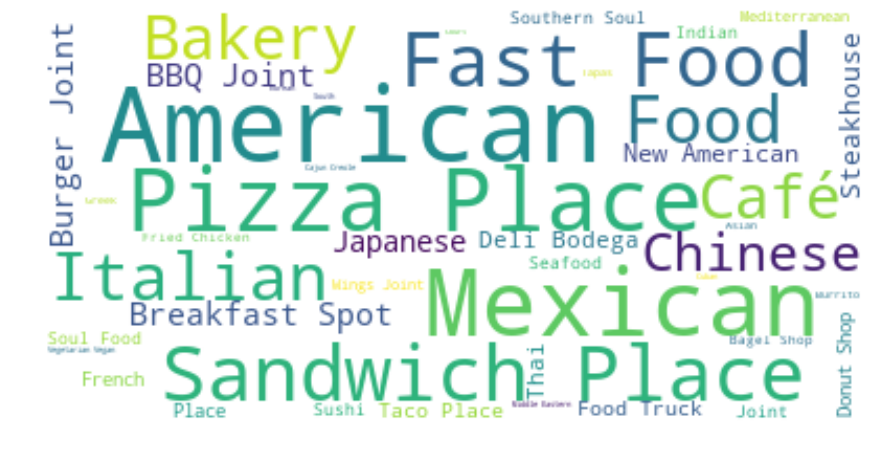

In [207]:
stop_words= ["Restaurant"]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stop_words,max_font_size=50,max_words=2000, background_color="white").generate(' '.join(venues_df['VenueCategory']))


# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


<h2>Identify how many categories show up within the specified radius from downtown

In [208]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 66 uniques categories.


In [210]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:75]

array(['Bakery', 'American Restaurant', 'New American Restaurant',
       'Steakhouse', 'Tapas Restaurant', 'Pizza Place',
       'Italian Restaurant', 'Café', 'Sandwich Place', 'Deli / Bodega',
       'Donut Shop', 'Breakfast Spot', 'Burger Joint',
       'Mexican Restaurant', 'Sushi Restaurant', 'Fast Food Restaurant',
       'Taco Place', 'French Restaurant', 'Indian Restaurant',
       'Mediterranean Restaurant', 'Asian Restaurant',
       'Hawaiian Restaurant', 'BBQ Joint', 'Chinese Restaurant',
       'Japanese Restaurant', 'Burrito Place', 'Food Truck',
       'Wings Joint', 'Buffet', 'Food Court', 'Tex-Mex Restaurant',
       'Restaurant', 'Cafeteria', 'Middle Eastern Restaurant',
       'Ramen Restaurant', 'Noodle House',
       'Vegetarian / Vegan Restaurant', 'Latin American Restaurant',
       'Hot Dog Joint', 'Greek Restaurant', 'Caribbean Restaurant',
       'Thai Restaurant', 'Fried Chicken Joint', 'Korean Restaurant',
       'South American Restaurant', 'Food', 'Snack P